Notebook to debug the MCS + NLLS approach.

In [71]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import os
import sys
from pathlib import Path

In [73]:
src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
os.environ["PYTHONPATH"] = src_dir

In [74]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune
import pmcx

import matplotlib.pyplot as plt

In [75]:
config.data_dir

PosixPath('/media/leon/T7/IDP')

In [76]:
config.spectra_dir

PosixPath('/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

In [77]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=20
)

delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

mu_a_matrix_old = loader.absorption_coefs_old(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix_static = data_loader.DataLoader.absorption_coefs(
    loader.wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

print(np.allclose(mu_a_matrix, mu_a_matrix_static))

/home/leon/anaconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


False


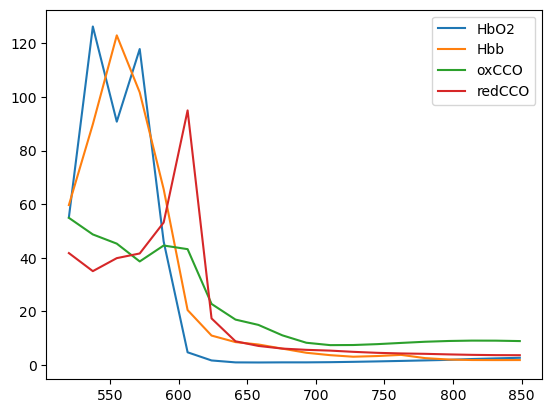

In [78]:
plot_spectra(mu_a_matrix_old[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

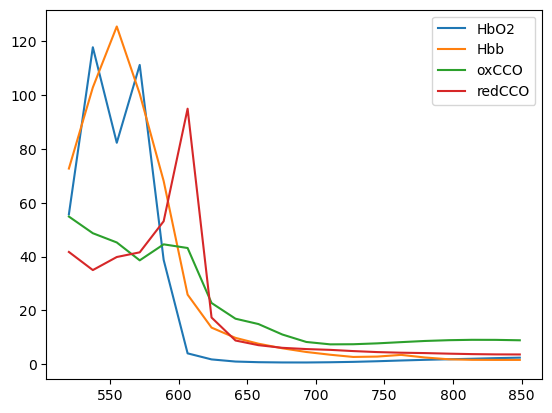

In [79]:
plot_spectra(mu_a_matrix[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

In [80]:
loader.wavelengths

array([520.        , 537.45454545, 554.90909091, 571.63636364,
       589.09090909, 606.54545455, 624.        , 641.45454545,
       658.18181818, 675.63636364, 693.09090909, 710.54545455,
       727.27272727, 744.72727273, 762.18181818, 779.63636364,
       797.09090909, 813.81818182, 831.27272727, 848.72727273])

In [81]:
mcs_obj1 = SimulationAttenuation(config.mcs_func_path.parent / "function_data1.npz")
mcs_obj2 = SimulationAttenuation(config.mcs_func_path.parent / "function_data2.npz")

Loaded data with 500000.0 photons and 30 values for mu_s.
Loaded data with 500000.0 photons and 30 values for mu_s.


Create spectrum with MCS and compare to MCS-func

In [ ]:
g_combined = 0.8675
refractive_index_combined = 1.38
vol = np.ones((50, 50, 100))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 1

cfg = {
    "nphoton": 1e8, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 1e8,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [83]:
mu_a_vals = loader.mu_a_func_gray_matter(loader.wavelengths)
mu_s_vals = loader.mu_s_red_func_gray_matter(loader.wavelengths)

In [84]:
A_mcs_generated = np.empty((loader.wavelengths.shape[0], ))

for i, wl in enumerate(loader.wavelengths):
    cfg["prop"][1, 0] = mu_a_vals[i] / 10
    cfg["prop"][1, 1] = mu_s_vals[i] / 10
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    print(f"Iteration {i}/{loader.wavelengths.shape[0]}")
    res = pmcx.mcxlab(cfg)
    weights = pmcx.utils.detweight(res["detp"])
    attenuation = -np.log(np.sum(weights)/cfg["nphoton"])
    A_mcs_generated[i] = attenuation

Iteration 0/20
nphoton: 1e+09
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+09
issrcfrom0: 1
autopilot: 1
unitinmm: 1


RuntimeError: PMCX terminated due to an exception!Error from thread (0): out of memory


In [23]:
A_mcs_func_computed1 = mcs_obj1.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

A_mcs_func_computed2 = mcs_obj2.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

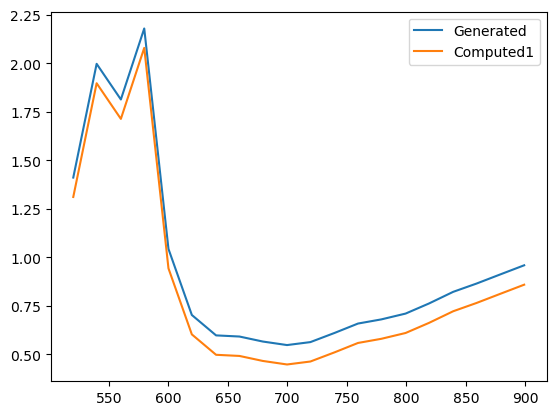

In [ ]:
plot_spectra(
    ( A_mcs_func_computed1, A_mcs_func_computed2),
    loader.wavelengths,
    labels=["Generated", "Computed1", "Computed2"]
)